In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.io import loadmat
import os

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

device

device(type='cuda', index=0)

In [ ]:
!pip install tqdm

In [ ]:
from tqdm.notebook import tqdm_notebook

### Load data

In [ ]:
# Importing drive method from colab for accessing google drive
from google.colab import drive
import glob

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = '/content/drive/My Drive/' #'/home/ab/Documents/DISK2TB/SaudiAramco/3D_geoproject/data/' 

In [ ]:
tresh = 127
data3d = (loadmat(data_path+'Normal_1_0.5.mat')["ctImage"] > tresh).astype(np.float)

### Model

In [ ]:
class FourierModel(torch.nn.Module):
    def __init__(self, sigma, grid_size, inp_dim=2, out_dim=1, hid_dim=10, num_fc_layers=3, 
                 num_freq=10, activation=F.relu, device=device, rotate=False, 
                 cut_freq=None, multipl=1.):
        super().__init__()
        self.num_freq = num_freq
        self.inp_dim = inp_dim
        self.out_dim = out_dim
        self.activation = activation
        self.grid_size = grid_size

        sigmas = torch.pow(sigma, torch.arange(num_freq)/float(num_freq))

        if cut_freq is not None:
            if sigma > 1:
                self.sigmas = torch.nn.Parameter(sigmas[:cut_freq], 
                                                 requires_grad=False) #.to(device)
            else:
                self.sigmas = torch.nn.Parameter(sigmas[num_freq-cut_freq:], 
                                                 requires_grad=False)#.to(device)
        else:
            self.sigmas = torch.nn.Parameter(sigmas,
                                             requires_grad=False)#.to(device)
        
        if cut_freq is None:
            self.num_freq = num_freq
        else:   
            self.num_freq = cut_freq


        layers = [torch.nn.Linear(inp_dim * self.num_freq * 2, hid_dim)]
        layers.extend([torch.nn.Linear(hid_dim, hid_dim) for _ in range(num_fc_layers-2)])
        layers.append(torch.nn.Linear(hid_dim, out_dim))
        self.nn = torch.nn.ModuleList(layers)
        self.W_enc = torch.randn(inp_dim, inp_dim*self.num_freq)
        
        self.rotate=rotate
        if rotate:
            if self.inp_dim == 2:
                self.rot_mat = torch.Tensor([[1,1],[1,-1]]).to(device)
            else:
                raise ValueError('higher dimensions for this case are not supported yet')

    def pos_encoding(self, x):
        if self.rotate:
            x = x@self.rot_mat
        x = 2 * np.pi * torch.einsum('...,i -> ...i', x, self.sigmas)
        x = x.flatten(-2,-1)
        return torch.cat([torch.sin(x), torch.cos(x)], dim=-1)

    def gauss_encoding(self, x):
        x = x@self.W_enc
        return torch.cat([torch.sin(x), torch.cos(x)], dim=-1)
    
    def forward(self, x):
        x = x.float()/(self.grid_size - 1)
        x_enc = self.pos_encoding(x)
        for l in self.nn[:-1]:
            x_enc = l(x_enc)
            x_enc = self.activation(x_enc)
        x_enc = self.nn[-1](x_enc)
        return torch.sigmoid(x_enc)

In [ ]:
md = FourierModel(1.5, 128, cut_freq=4, multipl=2.)
md = md.to(device)
md(torch.zeros((3,2), device=device))
#md(torch.zeros((3,2)))

tensor([[0.5447],
        [0.5447],
        [0.5447]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [ ]:
def train(model, dataloader, data, L, n_epochs=100):
    losses = []
    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-2)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=np.arange(100,301, 100), gamma=0.1)

    # optimizer = torch.optim.Adam(params=md.parameters(), lr=lr)

    for epoch in tqdm_notebook(range(3*n_epochs)):
        for x in dataloader:
            optimizer.zero_grad()
            indices = torch.stack(x, dim=-1).squeeze().T
            y_goal = data[list(indices.T)]
            y_predicted = model(indices.float().to(device))
            loss = L(y_predicted.squeeze(-1), y_goal.float()) 
            loss.backward(retain_graph=True)
            optimizer.step()
            losses.append(loss.detach())
        scheduler.step()
    return losses

### Data processing

In [ ]:
class DicreteDataset(Dataset):
    def __init__(self, shape):
        self.shape = shape

    def __len__(self):
        return np.prod(self.shape)

    def __getitem__(self, idx):
        indices = np.unravel_index(idx, self.shape)
        return indices


class PartialDataset(Dataset):
    def __init__(self, shape, mask):
        super().__init__()
        self.shape = shape
        self.mask = mask
        self.indices = np.arange(np.prod(shape))[mask.flatten()]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        idx = self.indices[idx]
        indices = np.unravel_index(idx, self.shape)
        
        return indices

In [ ]:
# Create masked dataset
k = 1
N_slices_approx = 4
data = data3d[::k,::k,::k]

Nx, Ny, Nz = data.shape
x = np.arange(Nx)
y = np.arange(Ny)
z = np.arange(Nz)

xx, yy, zz = np.meshgrid(x, y, z)

N = np.prod(xx.shape)

mask = np.zeros_like(data, dtype=np.bool)

selection = np.arange(Nx+1,step=Nx//N_slices_approx)[:-1,None]
selection_rand = selection+np.random.randint((Nx//N_slices_approx)//10,size=(selection.shape[0], 3))
selection_rand[0] = selection[0]
selection_rand[-1] = selection[-1]

mask[selection_rand[:,0]] = True 
mask[:, selection_rand[:,1]] = True
mask[:, :, selection_rand[:,2]] = True

ds_slices = PartialDataset(data.shape, mask)

### Training model

In [ ]:
# define model
sigma = 0.9
num_freq = 15
cut_freq = 13
md = FourierModel(sigma=sigma, grid_size=1/data.shape[0], inp_dim=3, num_fc_layers=4, num_freq=num_freq, 
                  hid_dim=100, rotate=False, cut_freq=cut_freq, multipl=8./k)
md = md.to(device)

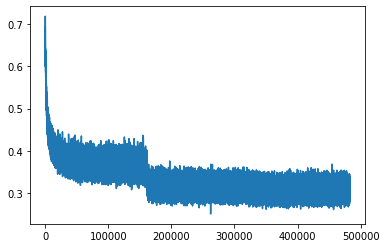

In [ ]:
# training loop
torch_data = torch.from_numpy(data).to(device)

sampler = torch.utils.data.sampler.BatchSampler(
    torch.utils.data.sampler.RandomSampler(ds_slices),
    batch_size=2048,
    drop_last=False)

dl = DataLoader(ds_slices, sampler=sampler)
L = torch.nn.BCELoss()

n_epochs = 100
losses = train(md, dl, torch_data, L, n_epochs=n_epochs)

plt.plot(losses)

In [ ]:
 class FullDataset(Dataset):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape
    def __len__(self):
        return np.prod(self.shape)
    def __getitem__(self, idx):
        idx_reshaped = np.unravel_index(idx, self.shape)
        return np.vstack([xx[idx_reshaped], yy[idx_reshaped], zz[idx_reshaped]]).T

In [ ]:
ds_full = DicreteDataset(xx.shape)

In [ ]:
xx[tuple(idx)].shape

()

In [ ]:
dl_full = DataLoader(ds_full, batch_size=1024)
result_np = np.zeros_like(xx)

for idx in tqdm_notebook(dl_full):
    idx = tuple(idx)
    #print(idx)
    x = xx[idx]
    y = yy[idx]
    z = zz[idx]
    x = torch.from_numpy(np.vstack([x, y, z]).T).to(device)
    #print(x.shape)
    pred = md(x).data.cpu().numpy().squeeze(-1)
    result_np[idx] = pred
    #break

### Visualization 

In [ ]:
'''
idx_full = np.concatenate([xx[:,:,:,None], yy[:,:,:,None], zz[:,:,:,None]], axis=-1)
idx_full_torch = torch.Tensor(idx_full).float()

splitted_idx = torch.split(idx_full_torch, 1)
res_list = []
for i in range(xx.shape[0]):
    
    res_list.append(md(t.to(device)).data.cpu().numpy().squeeze(-1))

res_full = np.concatenate(res_list, axis=0) 
'''

In [ ]:
def plot_selected_slices(selected_idx, res_full, data, mask, axis='z', idx_plot=1):
    res = res_full[selected_idx]

    plt.suptitle(axis+' slice', fontsize=14)
    plt.subplot(3, 2, 2*idx_plot-1)
    plt.imshow(res.T[:, :], cmap='gray')
    plt.title('generated ' + axis + ' slice')

    

    data_sel = data[selected_idx]
    '''
    mask_sel = mask[selected_idx]
    new_mask = np.zeros((mask_sel.shape[0], mask_sel.shape[1], 3), dtype=int)
    new_mask[mask_sel] = np.array([254,0,0])
    masked_data = new_mask.copy()
    data_rgb = np.zeros((data_sel.shape[0],data_sel.shape[1],3),dtype=int)
    data_rgb[data_sel==1,:] = np.array([255,255,255])
    masked_data[new_mask[:,:,0] == 0] = data_rgb[new_mask[:,:,0] == 0]
    '''

    plt.subplot(3, 2, 2*idx_plot)
    plt.imshow(data_sel, cmap='gray')
    plt.title('real ' + axis + ' slice')

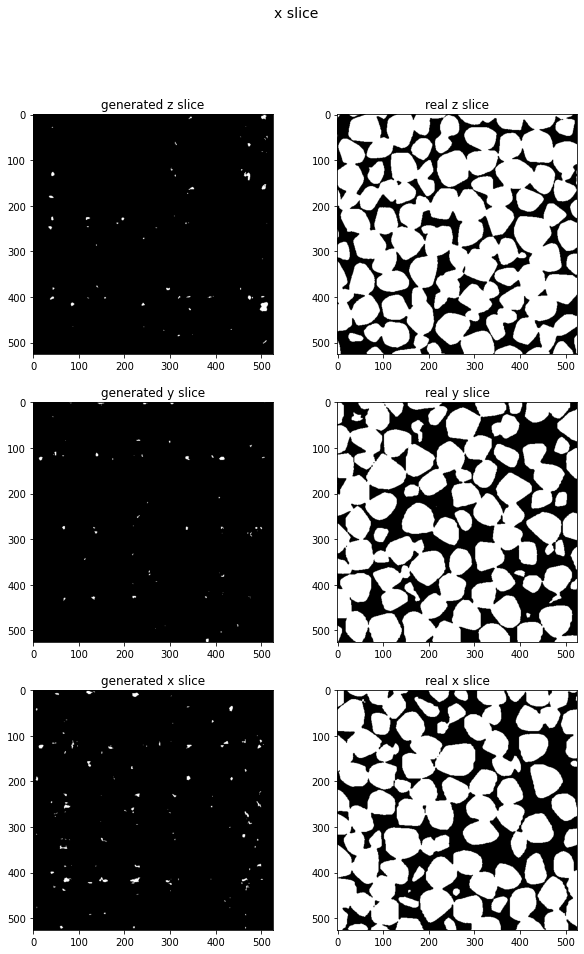

In [ ]:
# k = 16
sel_slice = 16

sel = (slice(None), slice(None), sel_slice)
plt.figure(figsize=(10,15))
plot_selected_slices(sel, result_np, data, mask, idx_plot=1)

sel = (slice(None), sel_slice, slice(None))
plot_selected_slices(sel, result_np, data, mask, axis='y', idx_plot=2)

sel = (sel_slice, slice(None), slice(None))
plot_selected_slices(sel, result_np, data, mask, axis='x', idx_plot=3)

### Properties

In [ ]:
# k = 1
thr = 0.5
res_3D = (result_np>thr).astype(int)
porosity = np.sum(data==0)/np.prod(data.shape)
porosity_res = np.sum(res_3D==0)/np.prod(res_3D.shape)

print('True porosity', porosity)
print('Result porosity', porosity_res)

True porosity 0.341522619118754
Result porosity 0.9891291289252582


In [ ]:
# 8
thr = 0.5
#res_3D = res_torch.data.cpu().numpy().squeeze(-1)
res_3D = (res_full>thr).astype(int)
porosity = np.sum(data==0)/np.prod(data.shape)
porosity_res = np.sum(res_3D==0)/np.prod(res_3D.shape)

print('True porosity', porosity)
print('Result porosity', porosity_res)

True porosity 0.3410795280629991
Result porosity 0.332126360018922


In [ ]:
from skimage.morphology import erosion
from scipy import ndimage as nd

Result, pseodo SSA: 0.23551632022706404


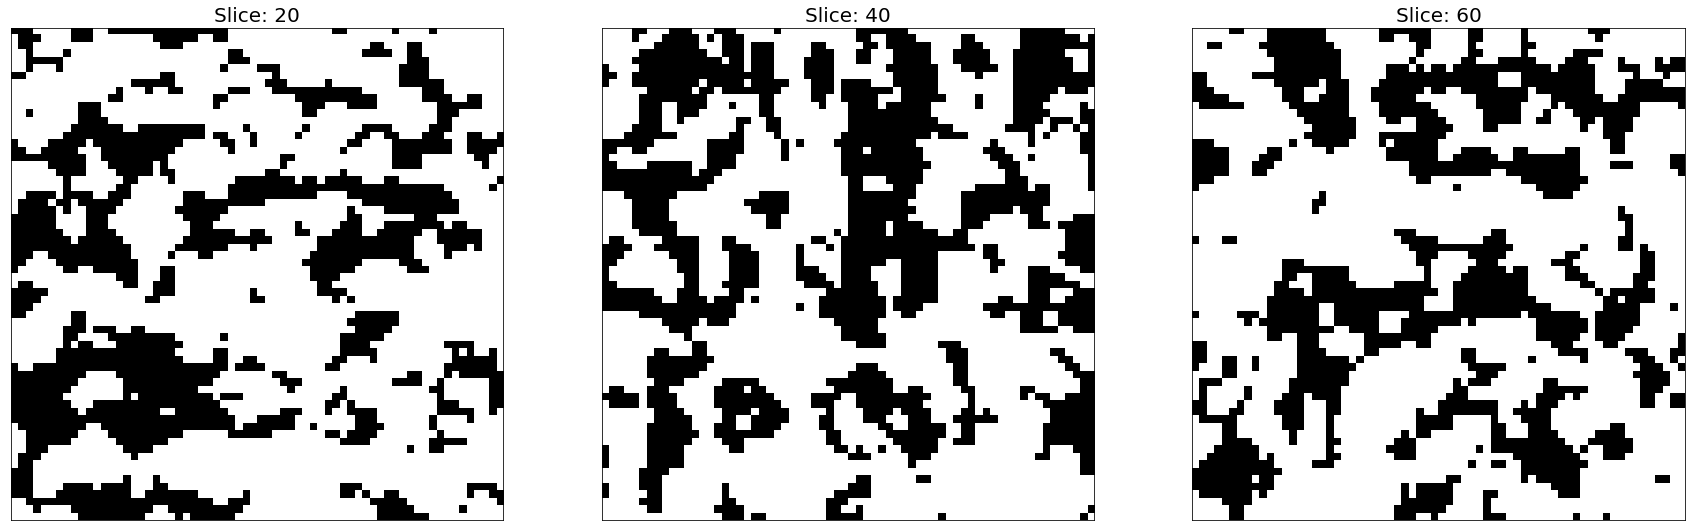

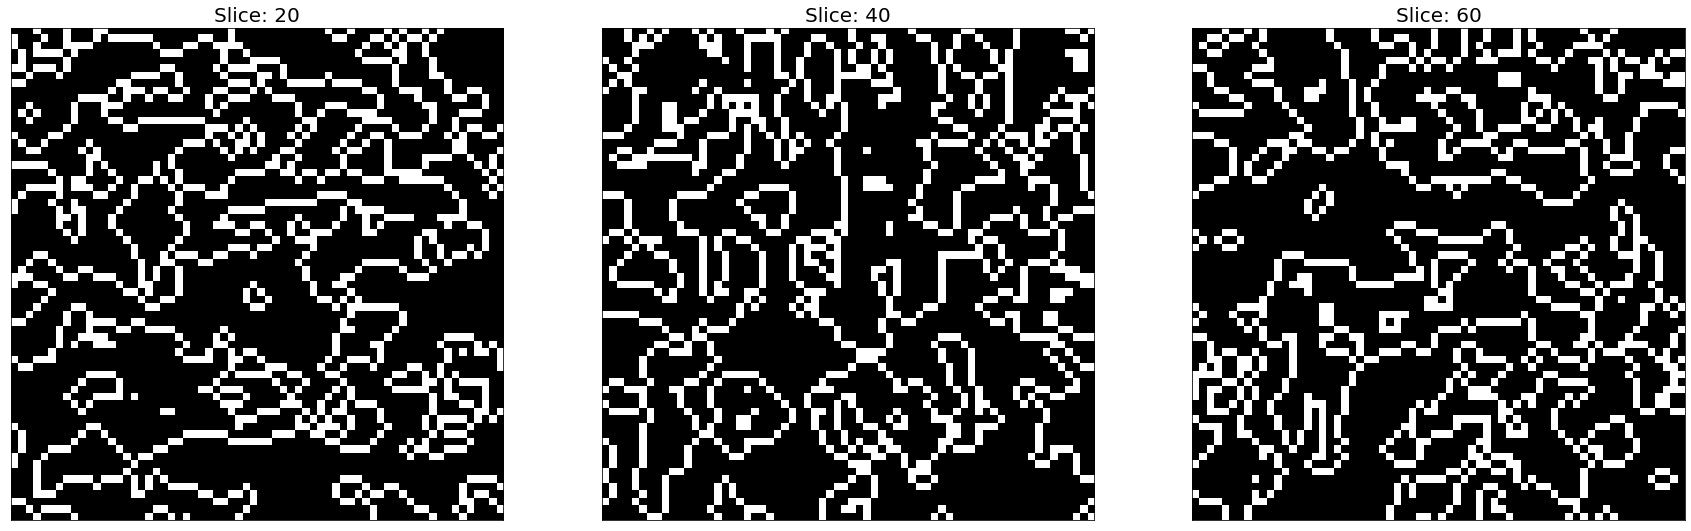

In [ ]:
def PlotSlice(image, sliceNumber):
    plt.imshow(image[:,:,sliceNumber], cmap="gray")
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.title("Slice: " + str(sliceNumber), size=20)

def PlotImage(image):
    plt.figure(figsize=(30,10))
    plt.subplot(1,3,1)
    PlotSlice(image, 20)
    plt.subplot(1,3,2)
    PlotSlice(image, 40)
    plt.subplot(1,3,3)
    PlotSlice(image, 60)



# Measure surface area
bwEdge = np.zeros(res_3D.shape)
for i in range(0, res_3D.shape[2]):
    image = np.squeeze(res_3D[:,:,i])
    bwEdge[:,:,i] = image - erosion(image)

PlotImage(res_3D)
PlotImage(bwEdge)

pseodoSSA = np.sum(bwEdge)/np.prod(bwEdge.shape)
print("Result, pseodo SSA: " + str(pseodoSSA))



True pseodo SSA: 0.2655306508612294


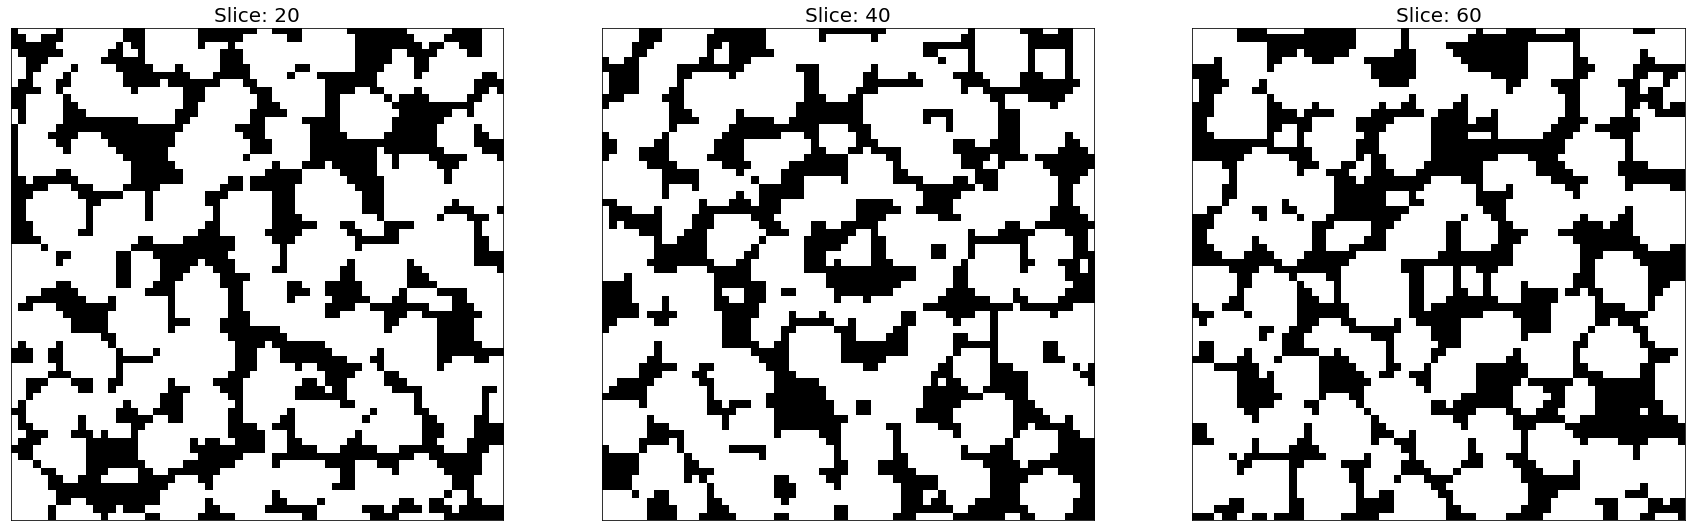

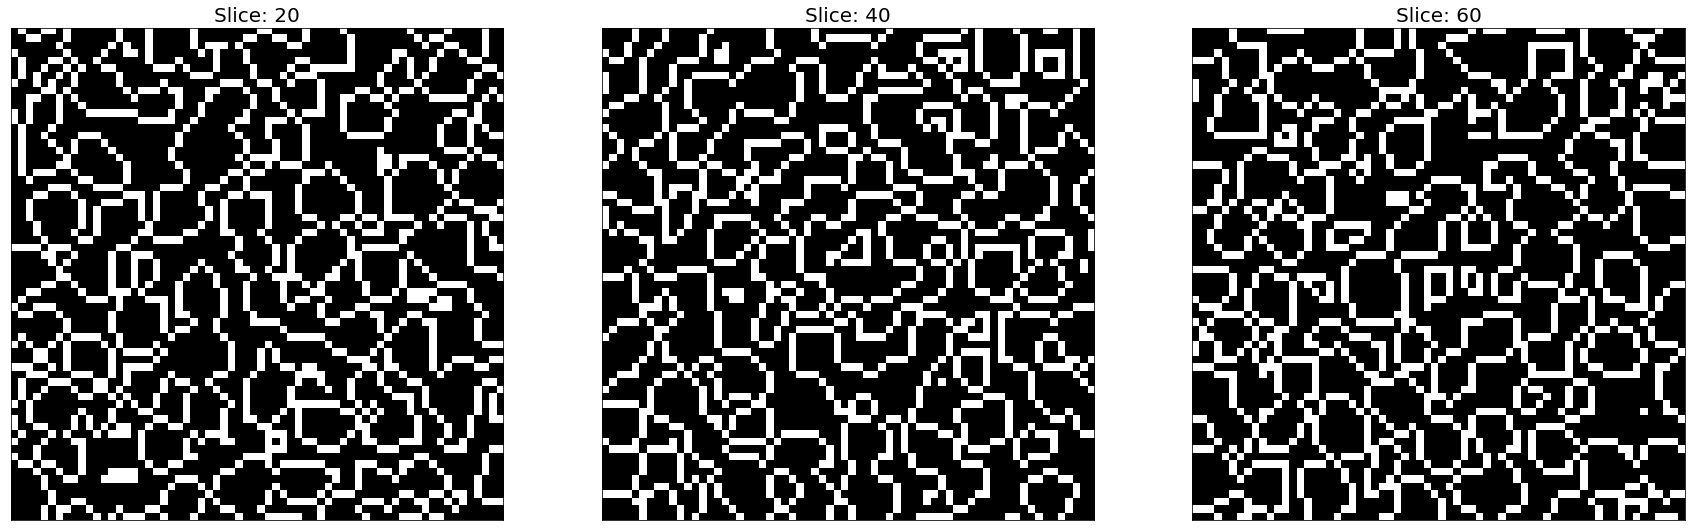

In [ ]:
# Measure surface area
bwEdge = np.zeros(data.shape)
for i in range(0, data.shape[2]):
    image = np.squeeze(data[:,:,i])
    bwEdge[:,:,i] = image - erosion(image)

PlotImage(data)
PlotImage(bwEdge)

pseodoSSA = np.sum(bwEdge)/np.prod(bwEdge.shape)
print("True pseodo SSA: " + str(pseodoSSA))

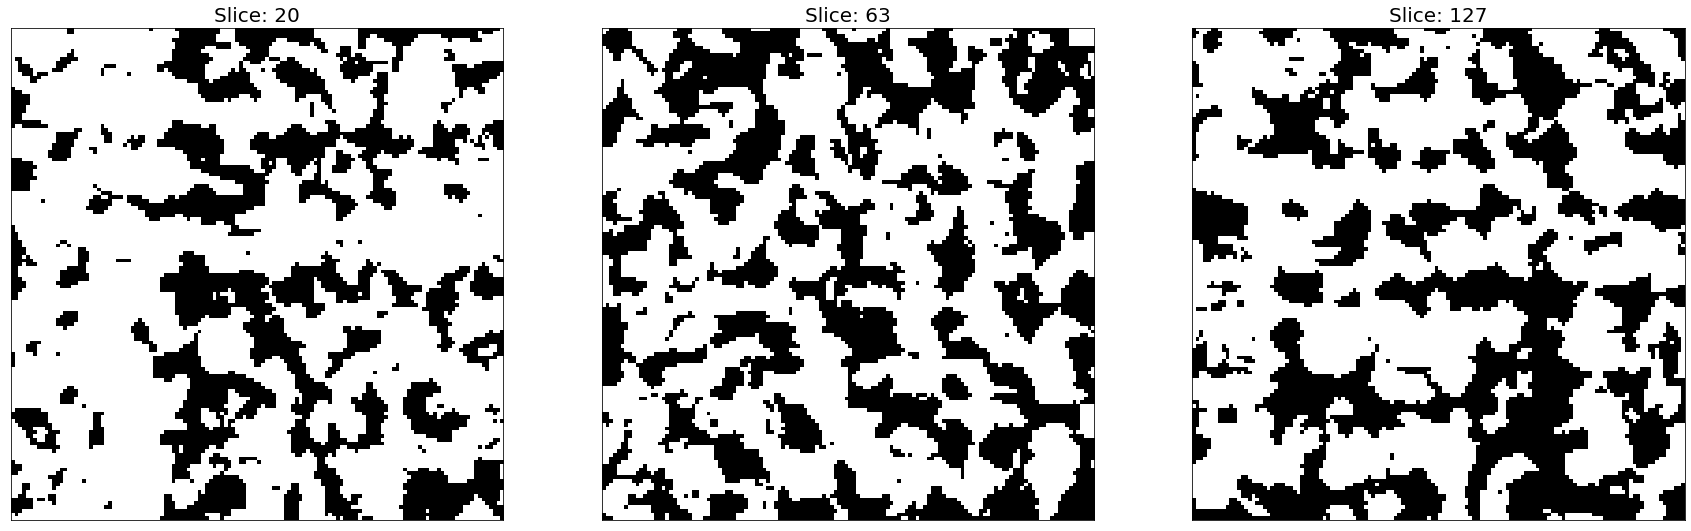

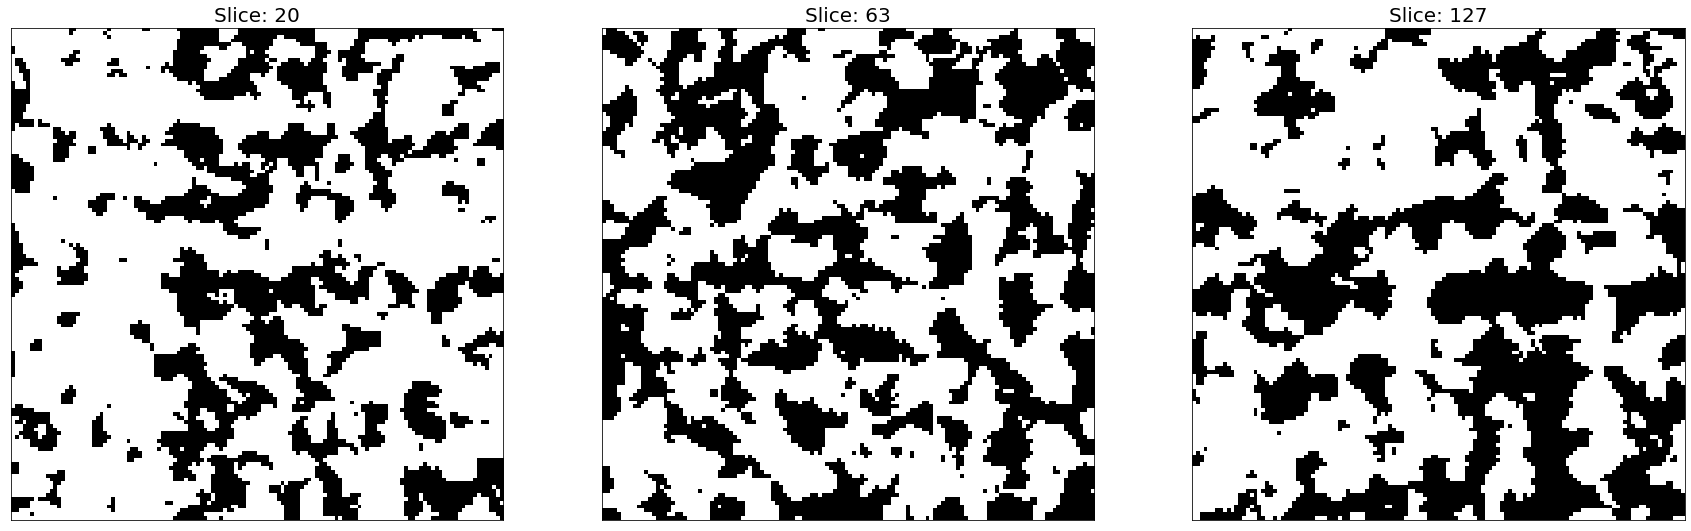

In [ ]:
# Resize the image for quicker simulation
nPixels = 128
dsfactor = [w/float(f) for w,f in zip((nPixels,nPixels,nPixels), res_3D.shape)]
bwImageThresholdSmall = nd.interpolation.zoom(res_3D.astype(np.float), zoom=dsfactor)
bwImageThresholdSmall = bwImageThresholdSmall > .5

# Quickly visualize the results
def PlotImageSmall(image):
    plt.figure(figsize=(30,10))
    plt.subplot(1,3,1)
    PlotSlice(image, 20)
    plt.subplot(1,3,2)
    PlotSlice(image, 63)
    plt.subplot(1,3,3)
    PlotSlice(image, nPixels-1)

PlotImageSmall(res_3D)
PlotImageSmall(bwImageThresholdSmall)


# Save the data
np.savetxt("data1.dat", bwImageThresholdSmall.flatten(), fmt='%1.0f')

In [ ]:
# Save the data for solver
np.savetxt("data1.dat", res_3D.flatten(), fmt='%1.0f')

In [ ]:
res_3D.shape

(66, 66, 66)

In [ ]:
bwImageThresholdSmall.shape

(128, 128, 128)

In [ ]:
# Run simulation
! "./Elas3D/Elas3DCsharp.exe"